In [1]:
from keras import applications
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Input
from keras.layers.normalization import BatchNormalization
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.utils import layer_utils, np_utils
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras import backend as K

Using TensorFlow backend.


In [2]:
train_dir = "D:/retinal_samples/basian_opt_testing/new_new_train/augmented_224/train"
validation_dir = "D:/retinal_samples/basian_opt_testing/new_valid"

image_width = 224
image_height = 224
batchsize = 16

vgg_16_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

In [3]:
vgg_16_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
def dataGen():
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(image_width, image_height),
        batch_size=batchsize,
        shuffle=True,
        class_mode='categorical')
    
    validation_generator = validation_datagen.flow_from_directory(
            validation_dir,
            target_size=(image_width, image_height),
            batch_size=batchsize,
            class_mode='categorical',
            shuffle=False)
    
    return train_generator, validation_generator

In [5]:
def trainValidationAccuracy(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [6]:
def modelBuilder(train_generator, validation_generator, intermediate_layer_model, path):
    # Compile the model
    intermediate_layer_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.Adam(lr=1e-4),
                  metrics=['acc'])
    
    # Train the model
    history = intermediate_layer_model.fit_generator(
          train_generator,
          steps_per_epoch=train_generator.samples//train_generator.batch_size ,
          epochs=30,
          validation_data=validation_generator,
          validation_steps=validation_generator.samples//validation_generator.batch_size,
          verbose=1)
    
    # Save the model
    intermediate_layer_model.save('D:/retinal_samples/basian_opt_testing/models/vgg16/' + path)
    trainValidationAccuracy(history)

In [7]:
train_generator, validation_generator = dataGen()

Found 2000 images belonging to 5 classes.
Found 113 images belonging to 5 classes.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

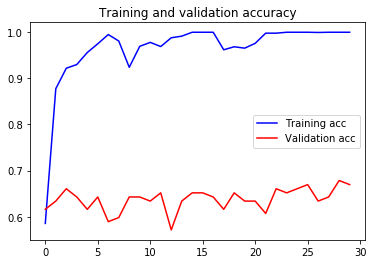

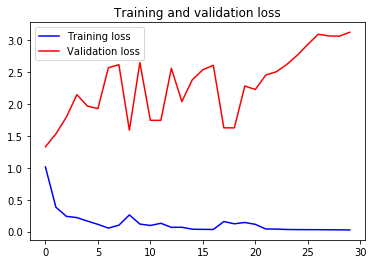

In [10]:
flatten = Flatten()
new_classifier_layer = Dense(5, activation='softmax', name='predictions', kernel_regularizer=regularizers.l2(0.01))

vgg_16_model_dup2 = vgg_16_model

inp_dup2 = vgg_16_model_dup2.input
#x = Dropout(0.1, name='maxpool_dropout')(vgg_16_model_dup2.output)
#out_dup2 = new_classifier_layer(flatten(x))
#out_dup2 = new_classifier_layer(flatten(vgg_16_model_dup2.output))
#out = new_classifier_layer(flatten(vgg_16_model_dup2.output))

x = flatten(vgg_16_model_dup2.output)
x = Dropout(0.5, name='flatten_dropout')(x)
out_dup2 = new_classifier_layer(x)

intermediate_layer_model_rcl1 = Model(inp_dup2, out_dup2)
intermediate_layer_model_rcl1.summary()

modelBuilder(train_generator, validation_generator, intermediate_layer_model_rcl1, 'vgg16_dr_rmFCdrp.h5')

In [62]:
# #vgg_16_model.summary()
# new_classifier_layer_3 = Dense(5, activation='softmax', name='my_dense_3', kernel_regularizer=regularizers.l2(0.0001))

# vgg_16_model_dup2 = vgg_16_model
# vgg_16_model_dup2.layers.pop()
# vgg_16_model_dup2.layers.pop()
# vgg_16_model_dup2.layers.pop()
# vgg_16_model_dup2.layers.pop()
# vgg_16_model_dup2.summary()

# inp_dup2 = vgg_16_model_dup2.input
# out_dup2 = new_classifier_layer_3(flatten(vgg_16_model_dup2.output))
# #out = new_classifier_layer(flatten(vgg_16_model_dup2.output))

# intermediate_layer_model_rcl1 = Model(inp_dup2, out_dup2)
# intermediate_layer_model_rcl1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [20]:
vgg_16_model.input

<tf.Tensor 'input_2:0' shape=(?, 224, 224, 3) dtype=float32>

In [ ]:
# model_input = Input(shape=(224,224,3),name = 'image_input')

# output_vgg16_conv = vgg_16_model(model_input)
# x = Dropout(0.1, name='maxpool_dropout')(output_vgg16_conv)
# x = Flatten(name='flatten')(output_vgg16_conv)
# x = Dense(5, activation='softmax', name='predictions', kernel_regularizer=regularizers.l2(0.001))(x)

# intermediate_layer_model_rFC = Model(inputs=model_input, outputs=x)
# intermediate_layer_model_rFC.summary()

# modelBuilder(train_generator, validation_generator, intermediate_layer_model_rFC, 'vgg16_dr_rmFC.h5')